# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [305]:
# Autograd & Numpy
import time as t
import numpy 
import autograd
import autograd.numpy as np
import numpy.linalg as lg

# Pandas
import pandas as pd
import math as m

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

In [2]:
def distance(X,Y):
    x1,x2 ,y1,y2 = X[0],X[1], Y[0],Y[1]
    return(m.sqrt((x1-y1)**2+(x2-y2)**2))

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)
print(grad(f)(1.,0.))

grad_f(1.0, 0.0) # array([1., 2.])
# g = autograd.grad
# print(g(f,0)(0.0,0.0))

[0.54030231 2.        ]


array([0.54030231, 2.        ])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

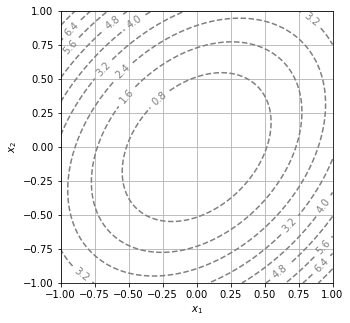

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [10]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2


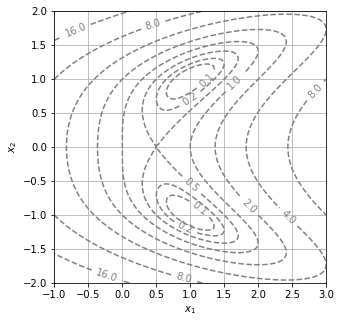

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

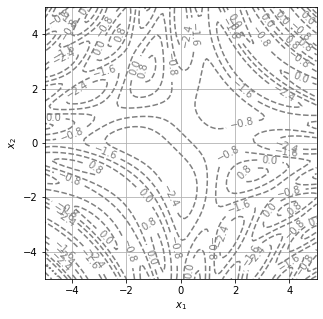

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [147]:
N0 = 1000
eps0 = 10**-6

# La précision dépend largement du contexte et on doit la prendre telle que les ordres de grandeurs en
# jeu dans le problème sont largement supérieur devant cette précision
# Dans notre cas les grandeurs en jeu dans les exemple sont de l'ordre de 1 ou 10^-1 donc 10**-4 est largement
# suffisant



**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [339]:
def Newton(F,x0,y0,eps=eps0,N=N0):
    ''' Entrée : F fonction de R^2 dans R^2, (x0,y0) point de départ, eps précision sur les coordonnées (x,y), 
            N nombre d'itération maximal
        Sortie : coordonnées (x,y) d'un zéro de la fonction F '''
    
    J_F = J(F) # calcul de la matrice jacobienne de F
    x,y = x0,y0
    
    for i in range(N):
        
        sol = lg.solve(J_F(x0,y0),F(x0,y0)) # revient au produit de l'inverse de J_F(x0,y0) avec F(x0,yO)
        x,y = x0-sol[0],y0-sol[1] # calcul des nouveaux termes des suites récurrentes dans la méthode de Newton
        
        if distance((x,y),(x0,y0)) <= eps: # si le nouveau point est suffisamment proche du précédent, on s'arrête
            return [x,y]
        
        x0,y0=x,y # si la précision n'est pas suffisante, on continue le calcul des nouveaux termes de la suite
        
    else :
        raise ValueError(f"no convergence in {N} steps" ) # si la précision voulue n'est pas atteinte au bout de N
                                                          # itérations, on arrête l'algorithme sur une erreur

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

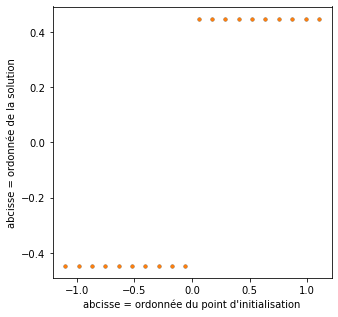

In [340]:
abcisses, ordonnées = [],[] # on va trouver des couples de solution et les stocker pour reconstituer une
                            # courbe de niveau

# Avec la contrainte x = y

def F1(x,y):
    ''' Fonction dont l'on va chercher le zéro par Newton
        On translate f1 de -0.8 et on ajoute la contrainte x = y '''
    return np.array([f1(x,y)-0.8,x-y])

# Remarque : (0,0) ne peut être choisi comme point d'initialisation car il s'agit d'un point stationnaire 

L1 = np.linspace(-1.1,1.1,20) # liste des points d'initialisation, en évitant (0,0)

solution1 = [Newton(F1,x,x) for x in L1]

# Tracés des solutions trouvées
plt.xlabel("abcisse = ordonnée du point d'initialisation") # x0,y0 entré en argument dans Newton
plt.ylabel("abcisse = ordonnée de la solution") # x,y renvoyé par Newton
plt.plot(L1,solution1, '.')
plt.show()


# On trouve deux points : un de coordonnées négatives (resp. positives) si l'on initialise avec un point
# de coordonnées négatives (resp. positives)
# Les points trouvés sont cohérents avec la courbe de niveau fournie plus haut


abcisses.append(solution1[0][0])
ordonnées.append(solution1[0][1]) # on note les coordonnées de la solution positive
abcisses.append(solution1[-1][0]) 
ordonnées.append(solution1[-1][1]) # puis de la négative
# Remarque : on a choisit que le point d'initialisation ait son ordonnée et son abcisse égales 
# mais c'est arbitraire

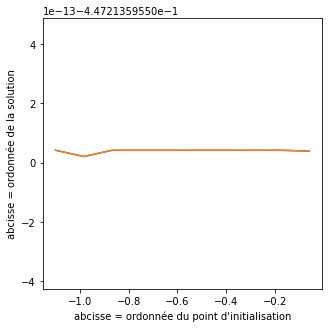

In [341]:
# Zoom sur une des solutions

plt.xlabel("abcisse = ordonnée du point d'initialisation")
plt.ylabel("abcisse = ordonnée de la solution")
plt.plot(L1[:10],solution1[:10])
# plt.ylim([-0.448,-0.446]) ça marche pas
plt.show()

# Conclusion : dépendance faible au point d'initialisation une fois le signe fixé

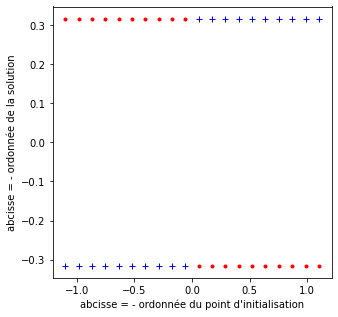

In [342]:
# Avec la contrainte x = -y

def F2(x,y):
    ''' Fonction dont l'on va chercher le zéro par Newton
        On translate f1 de -0.8 et on ajoute la contrainte x = -y '''
    return np.array([f1(x,y)-0.8,x+y])
    
solution2 = [Newton(F2,x,-x) for x in L1]
ab = [s[0] for s in solution2]
ordo = [s[1] for s in solution2]

# Tracés des solutions trouvées
plt.xlabel("abcisse = - ordonnée du point d'initialisation")
plt.ylabel("abcisse = - ordonnée de la solution")
plt.plot(L1,ab,'b+')
plt.plot(L1, ordo, 'r.')
plt.show()

# On trouve deux points opposés comme précédemment
# On a bien respect de la contrainte (x = -y) vu les deux courbes


abcisses.append(solution2[0][0]) # Idem que précédemment
ordonnées.append(solution2[0][1])
abcisses.append(solution2[-1][0]) 
ordonnées.append(solution2[-1][1])


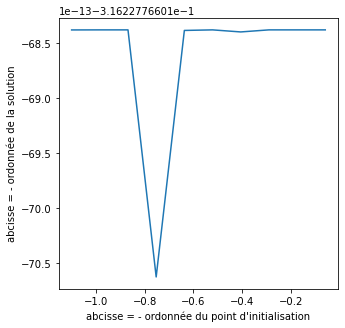

In [343]:
# Zoom sur une des solutions

plt.xlabel("abcisse = - ordonnée du point d'initialisation")
plt.ylabel("abcisse = - ordonnée de la solution")
plt.plot(L1[:10],ab[:10])
plt.show()

# Conclusion : dépendance faible au point d'initialisation une fois le signe fixé (pic important du au choix
# de l'échelle)

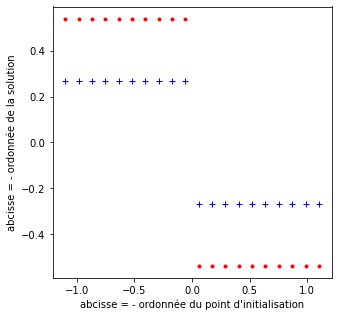

In [344]:
# Avec la contrainte x = 0.5*y

def F3(x,y) :
    ''' Fonction dont l'on va chercher le zéro par Newton
        On translate f1 de -0.8 et on ajoute la contrainte x = 0.5*y '''
    return np.array([f1(x,y)-0.8,x-0.5*y])
    
solution3 = [Newton(F3,x,-x) for x in L1]

ab = [s[0] for s in solution3]
ordo = [s[1] for s in solution3]

# Tracés des solutions trouvées
plt.xlabel("abcisse = - ordonnée du point d'initialisation")
plt.ylabel("abcisse = - ordonnée de la solution")
plt.plot(L1,ab,'b+' )
plt.plot(L1, ordo, "r.")
plt.show()

# Mêmes remarques

abcisses.append(solution3[0][0]) 
ordonnées.append(solution3[0][1])
abcisses.append(solution3[-1][0]) 
ordonnées.append(solution3[-1][1])


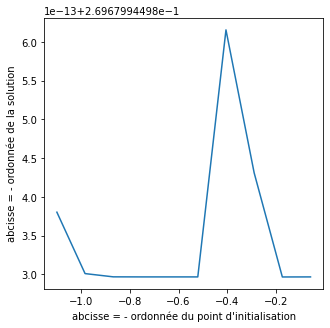

In [345]:
# Zoom sur une des solutions

plt.xlabel("abcisse = - ordonnée du point d'initialisation")
plt.ylabel("abcisse = - ordonnée de la solution")
plt.plot(L1[:10],ab[:10])
plt.show()

# Mêmes conclusion : peu de dépendance de la solution au point d'initialisation (là encore, prendre garde 
# à l'échelle)


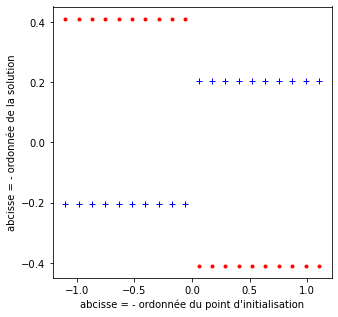

In [346]:
# Avec la contrainte x = -0.5*y

def F4(x,y) :
    ''' Fonction dont l'on va chercher le zéro par Newton
        On translate f1 de -0.8 et on ajoute la contrainte x = -0.5*y '''
    return np.array([f1(x,y)-0.8,x+0.5*y])
    
solution4 = [Newton(F4,x,-x) for x in L1]

ab = [s[0] for s in solution4]
ordo = [s[1] for s in solution4]

# Tracés des solutions trouvées
plt.xlabel("abcisse = - ordonnée du point d'initialisation")
plt.ylabel("abcisse = - ordonnée de la solution")
plt.plot(L1,ab,'b+' )
plt.plot(L1, ordo, "r.")
plt.show()

abcisses.append(solution4[0][0]) 
ordonnées.append(solution4[0][1])
abcisses.append(solution4[-1][0])
ordonnées.append(solution4[-1][1])


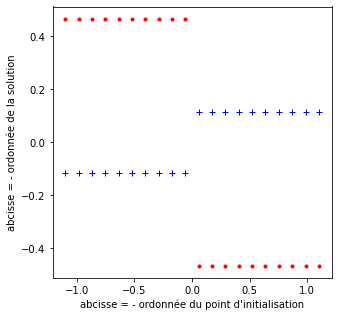

In [347]:
# Avec la contrainte x = -0.25*y
def F5(x,y) :
    ''' Fonction dont l'on va chercher le zéro par Newton
        On translate f1 de -0.8 et on ajoute la contrainte x = -0.25*y '''
    return np.array([f1(x,y)-0.8,x+0.25*y])
    

solution5 = [Newton(F5,x,-x) for x in L1]

ab = [s[0] for s in solution5]
ordo = [s[1] for s in solution5]

# Tracés des solutions trouvées
plt.xlabel("abcisse = - ordonnée du point d'initialisation")
plt.ylabel("abcisse = - ordonnée de la solution")
plt.plot(L1,ab,'b+' )
plt.plot(L1, ordo, "r.")
plt.show()

abcisses.append(solution5[0][0]) 
ordonnées.append(solution5[0][1])
abcisses.append(solution5[-1][0])
ordonnées.append(solution5[-1][1])


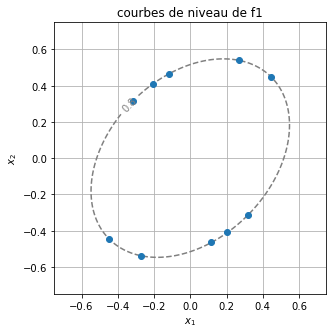

In [350]:
# Tracé de la courbe de niveau obtenue

# On voit que la forme qui se dessine correspond bien à la forme attendue
display_contour(
    f1, 
    x=np.linspace(-0.75, 0.75, 100), 
    y=np.linspace(-0.75, 0.75, 100), 
    levels=np.array([0.8]) # 10 levels, automatically selected
)
plt.title("courbes de niveau de f1")
plt.plot(abcisses,ordonnées,"o")
plt.show()


### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [349]:
def norme(vect):
    ''' Entrée : vect np.array à deux composantes
        Sortie : norme euclidienne du vecteur vect '''
    x,y = vect[0],vect[1]
    return (x**2+y**2)**0.5

In [183]:
delta1 = 0.1
N1 = 1000

## Changer la forme de la solution en np.array !!!

def level_curve(f, x0, y0, delta=delta1, N1=N1, eps=eps0) :
    ''' Entrée : (x0,y0) un point de la courbe de niveau, delta distance entre les points que l'on souhaite 
            récupérer, N nombre d'itérations maximal, eps précision pour Newton
        Sortie : liste de points de la courbe de niveau de valeur f(x0,y0) '''
    
    Result = np.zeros((2,N)) # liste qui contiendra les points de la courbe de niveau
    c = f(x0,y0)
    
    Result[0,0],Result[1,0] = x0,y0
    
    for k in range(1,N) :
        
        def h(x,y) :
            return(f(x,y)-c)
        
        def F1(x,y) :
            ''' fonction dont on va chercher le 0 à l'aide de Newton '''
            return np.array([h(x,y),distance((x,y),(x0,y0))-delta])
        
        
        gradient = grad(f)(x0,y0) # calcul du gradient
        gradiDelta = delta * gradient/norme(gradient) # gradient mais de norme delta (pour se deplacer sur le cercle)
        xd, yd = gradiDelta[0], gradiDelta[1]
        
        xi,yi = x0+yd, y0-xd # on calcule les coordonnees du point d'initialisation de Newton
                             # en tournant le gradient de -pi/2 
        
        Solution = Newton(F1,xi,yi,eps,N) # nouveau point de la courbe de niveau
        
        x0,y0 = Solution[0],Solution[1]
        Result[0,k],Result[1,k] = x0,y0 # on ajoute la nouvelle solution aux précédentes
        
        
        
    return Result

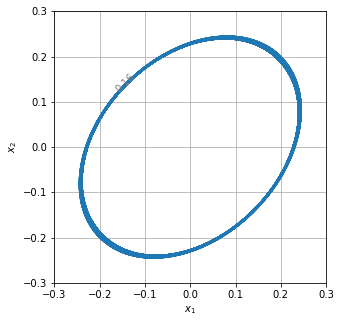

In [184]:
# Test de la fonction level_curve sur une courbe de niveau de f1

solution = level_curve(f1,0.2,0.2,0.1,N1=1000)

abcisse = solution[0,:]
ordonnee = solution[1,:]

display_contour(
    f1, 
    x=np.linspace(-0.3, 0.3, 100), 
    y=np.linspace(-0.3, 0.3, 100), 
    levels=np.array([f1(0.2,0.2)]) 
)

plt.plot(abcisse,ordonnee)
plt.show() # on trouve le résultat attendu en terme d'allure

# On remarque que la courbe de niveau est "épaisse" car on repasse plusieurs fois au même endroit
# Ce n'est pas souhaitable (c'est inutile, ça augmenter de la complexité et nous fait perdre en précision)


### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [351]:
delta1 = 0.1
N1 = 1000

def level_curve_improved(f, x0, y0, delta=delta1, N1=N1, eps=eps0) :
    ''' Même fonction que level curve mais qui ne refait pas plusieurs fois le tour de la même courbe de niveau'''
    
    # Principe : on va utiliser comme condition le fait que la dernière solution soit à distance
    # inférieure à delta de la première, ce qui montrera que l'on repasse par le "début" de la courbe de niveau
    Result = np.zeros((2,N))
    Result[0,0], Result[1,0] = x0, y0
    
    c = f(x0,y0)
    k = 1 # pas 0 car on a déjà la premier élement de Result
    xdébut,ydébut = x0,y0 # on stock les coordonnées du 1er point
    d = delta # variable qui stockera la distance de la dernière solution au premier point
              # on lui assigne la valeur de delta pour être sur de rentrer dans le while au premier passage
    
    while (k<N and d>=delta-eps) :
        
        
        def h(x,y) :
            return f(x,y)-c
        
        def F1(x,y) :
            '''fonction dont on va chercher le 0'''
            return np.array([h(x,y),distance((x,y),(x0,y0))-delta])
        
        
        gradient0 = grad(f)(x0,y0) # calcul du gradient
        gradiDelta = delta * gradient0/norme(gradient0) # gradient mais de norme delta (pour se deplacer sur le cercle)
        xd, yd = gradiDelta[0], gradiDelta[1]
        
        xi,yi = x0+yd, y0-xd # on calcule les coordonnees du point d'initialisation de Newton
                             # en tournant le gradient de -pi/2 
        
        Solution = Newton(F1,xi,yi,eps,N) # nouveau point de la courbe de niveau
        xnouveau,ynouveau = Solution [0], Solution[1] # dont on extrait les coordonnées
        
        gradientnouveau = grad(f)(xnouveau,ynouveau)
        
        
        x0,y0 = xnouveau,ynouveau
        d = distance((xnouveau,ynouveau),(xdébut,ydébut))
        Result[0,k],Result[1,k] = xnouveau, ynouveau
        
        k = k + 1
    Result = Result[:,:k]
        
        
    
    return Result

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

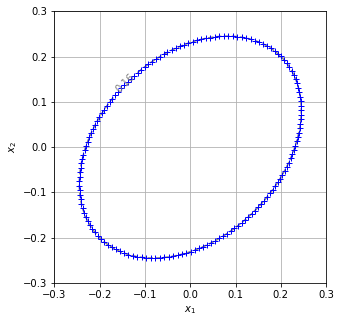

In [354]:
#test sur une courbe de niveau de f1 choisie de façon arbitraire
sol = level_curve_improved(f1,0.2,0.2,0.01,N1=1000)
ab = sol[0,:]
ordo = sol[1,:]
display_contour(
    f1, 
    x=np.linspace(-0.3, 0.3, 100), 
    y=np.linspace(-0.3, 0.3, 100), 
    levels=np.array([f1(0.2,0.2)]) # 10 levels, automatically selected
)

plt.plot(ab,ordo,'b+')
plt.show()

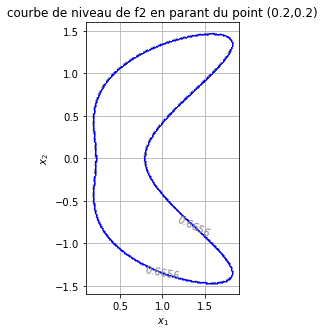

In [355]:
# Test de la fonction précedente sur une courbe de niveau de f2

sol = level_curve_improved(f2,0.2,0.2,0.01,N1=1000)
ab = sol[0,:]
ordo = sol[1,:]
display_contour(
    f2, 
    x=np.linspace(0.1, 1.8, 100), 
    y=np.linspace(-1.6, 1.6, 100), 
    levels=np.array([f2(0.2,0.2)]) 
)
plt.title('courbe de niveau de f2 en parant du point (0.2,0.2)')
plt.plot(ab,ordo,'b+',markersize = 1)
plt.show()

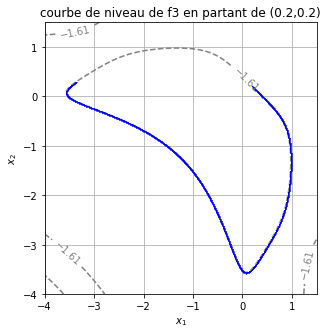

In [356]:
# Test de la fonction précedente sur une courbe de niveau de f3
sol = level_curve_improved(f3,0.2,0.2,0.01,N1=1000)
ab = sol[0,:]
ordo = sol[1,:]
display_contour(
    f3, 
    x=np.linspace(-4., 1.5, 100), 
    y=np.linspace(-4., 1.5, 100), 
    levels=np.array([f3(0.2,0.2)])) 
    
plt.title("courbe de niveau de f3 en partant de (0.2,0.2)")
plt.plot(ab,ordo,'b+',markersize = 1.)
plt.show()
# Ici, la courbe n'est pas close car N est trop faible et le périmètre de la courbe de 
# niveau est très supérieur à N*delta

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [302]:
delta0 = 0.01
N0 = 1000
eps0 = 10**(-6)

# Détermination du contour de l'ensemble K (nécessite un point de départ x0,y0)
# abscisses, ordonnees = level_curve_improved(f,x0,y0)[0], level_curve_improved(f,x0,y0)[1]

def aera_squares(f,c,h,ab,ordo) :
    ''' Entrée : distribution f (fonction de plusieurs variables, à valeurs dans une dimension), valeur c 
            qui délimite l'ensemble K, h valeur infinitésimale
        Sortie : aire approximée de l'ensemble K '''
    
    
    # calcule le côté du carré qui recouvre K ainsi que son coin droit supérieur
    max_a = np.max(ab)
    max_o = np.max(ordo)
    largeur = np.max(ab)-np.min(ab)
    hauteur = np.max(ordo)-np.min(ordo)
    x,y = max_a,max_o
    cote = np.max((largeur,hauteur)) 
    
    compteur = 0 # compte le nombre de carrés de côté h contenus dans K
    for i in range (int(cote/h)) :
        for i in range (int(cote/h)) :
            if f(x,y) <= c :
                compteur += 1
            y -= h
        x -= h
        y = max_o
    return compteur*h**2

# aera_squares_vect = np.vectorize(aera_squares)

In [263]:
# Test sur la fonction Norme (définie à partir de norme, voir plus haut)

def Norme(x,y) :
    return norme((x,y))

abscisses, ordonnees = level_curve_improved(Norme,0.,1.)[0], level_curve_improved(Norme,0.,1.)[1]
aera_squares(Norme,1.,0.001, abscisses,ordonnees) # on prend la courbe de niveau Norme = 1 pour obtenir le disque unité

# Renvoie effectivement l'aire du disque unité (environ 3.14)

3.141399

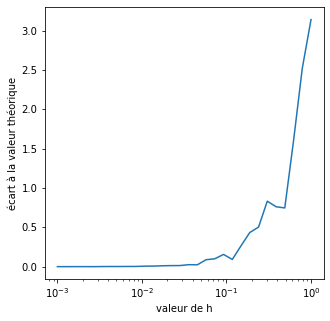

In [276]:
# Tracé de l'erreur |Ah-A| en échelle log fonction de h lorsque h tend vers 0

abscisses, ordonnees = level_curve_improved(Norme,0.,1.)[0], level_curve_improved(Norme,0.,1.)[1]

H = [10**(-k) for k in np.linspace(0,3,30)]
Aire = [aera_squares(Norme,1.,h,abscisses, ordonnees) for h in H]
Erreur = [np.abs(Ah-np.pi) for Ah in Aire]

plt.xscale("log")
plt.xlabel('valeur de h')
plt.ylabel('écart à la valeur théorique')
plt.plot(H,Erreur)
plt.show()



**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [236]:
# On souhaite d'abord obtenir une minoration de l'aire recherchée. 
# Pour cela, on cherche les ensembles de points (carrés) vérifiant la condition f < c

def minoration_squares(f,c,h, ab,ordo) :
    ''' Entrée : distribution f (fonction de plusieurs variables, à valeurs dans une dimension), valeur c 
            qui délimite l'ensemble K, h valeur infinitésimale
        Sortie : aire approximée de l'ensemble K '''
    
    # calcule le côté du carré qui recouvre K ainsi que son coin droit supérieur
    max_a = np.max(ab)
    max_o = np.max(ordo)
    largeur = np.max(ab)-np.min(ab)
    hauteur = np.max(ordo)-np.min(ordo)
    x,y = max_a,max_o
    cote = np.max((largeur,hauteur)) 
    
    # Les points étudiés ne sont plus les centres mais les sommets des carrés de côté h
    compteur = 0 # compte le nombre de carrés de côté h contenus dans K
    for i in range (int(cote/h)) :
        for i in range (int(cote/h)) :
            if f(x,y) <= c :
                if f(x-h,y)<=c and f(x,y-h)<=c and f(x-h,y-h)<=c :
                    compteur += 1
            y -= h
        x -= h
        y = max_o
        
    return compteur*h**2

minoration_squares_vect = np.vectorize(minoration_squares)
    

In [238]:
# Test minoration

abscisses, ordonnees = level_curve_improved(Norme,0.,1.)[0], level_curve_improved(Norme,0.,1.)[1]
H = np.array([10**(-k) for k in range (1,5)])
Aire = minoration_squares(Norme,1,0.01,abscisses, ordonnees)

Aire


31010
0.01


3.101

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [357]:
def triangle_level2(Z,P):
    '''renvoie l aire du domaine de frontière Z depuis le point P par la méthode des triangles
    Z est un array de taille (2,N), avec la ligne des abcisses et celle des ordonnées
    P est un tuple'''
    
    xp, yp = P
    aire = 0
    
    for k in range(len(Z[0,:])):
        
        if k == len(Z[0,:])-1:#le dernier triangle est celui le dernier et le premier point
            x1,y1 = Z[0,0],Z[1,0]#on a dans ce cas "zk+1 = z0"
        else : 
            x1,y1 = Z[0,k+1],Z[1,k+1]
       
        x0,y0 = Z[0,k],Z[1,k]#extraction des coordonées des sommets
        
        aire = aire + float(numpy.cross((x1,y1),(x0,y0))/2) 
        #produit vectoriel donne un vecteur donc la longueur indique l'aire algébrique d'un parallélogramme d'aire
        #double par rapport au triangle recherché
        #on convertit le produit vectoriel de type array (taille 1) en flottant
        
    return(abs(aire))  

In [358]:
def cercle(x,y):
    
    return((x**2+y**2)**0.5)


In [246]:
#Test sur un cercle de rayon 1 avec le point intérieur (0,0)
P = (0.,0.)
D = [0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.01,0.05,0.025]
Z = [level_curve_improved(cercle,1.,0.,delta = d, eps = 10**-6) for d in D]
aire = [triangle_level2(Z0,P) for Z0 in Z]
aires
#conclusion : ça converge bien vers pi quand delta décroit


[2.889359141362557,
 2.9559191526893938,
 3.013295590487726,
 3.059427411290516,
 3.0948178145855114,
 3.1208315018881145,
 3.1363784885316863,
 3.1415403172365854,
 3.14028745649953,
 3.141265772334386]

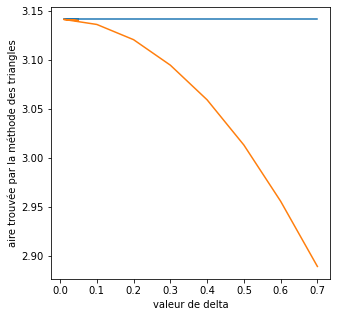

In [359]:
#tracé de l'aire en fonction de la valeur de delta
plt.xlabel('valeur de delta')
plt.ylabel('aire trouvée par la méthode des triangles')
plt.plot(D,[numpy.pi]*len(D))#on trace l'asymtote atttendue
plt.plot(D,aires)
plt.show()


**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [360]:
Lorsque le point de départ est hors de la courbe, les triangles vont être en partie hors de celle-ci.
On va donc, en ajoutant leur aire toute entière au compteur, ajouter en partie une aire qui est hors
de la courbe de niveau. Cependant, cette aire "de trop" sera soustraite par la suite au total. En effet,
on va balayer cette zone deux fois, une fois positivement et une fois négativement (puisque
le produit vectoriel est signé) ce qui permet finalement ne compter que l aire bel et bien dans la courbe.

SyntaxError: invalid syntax (<ipython-input-360-9e30c5828ab5>, line 1)

In [361]:
#verification de la validité pour un point P en dehors du cercle unité
P0 = (3.,3.)
Z2 = level_curve_improved(cercle,1., 0.,delta = 0.01,eps = 10**-6)
print(triangle_level2(Z2,P0))

3.141540317236586


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [254]:
x1,y1 = 2,2

def cercle2(x,y):
    
    '''equation cercle de centre (x1,y1)'''
    
    return(((x-x1)**2+(y-y1)**2)**0.5)

In [363]:
#vérification de la validité pour K non convexe

K = np.concatenate((level_curve_improved(cercle,1., 0.,delta = 0.01,eps = 10**-6),level_curve_improved(cercle2,2., 3.,delta = 0.01,eps = 10**-6)),axis=1)
P0 = (5.,5.)
solution = triangle_level2(K,P0)
print(solution,f"écart relatif {abs((solution-2*numpy.pi)/2*numpy.pi)}")
#on tombe sur le résultat attendu

6.279931479668017 écart relatif 0.005111100303197455


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [248]:
def area_triangles(Z):
    '''calcule avec la méthode des triangles l aire de la courbe de niveau décrite par Z = (xi,yi)
    Z est un numpy de taille (2,N) avec la ligne 0 correspondant aux abcisses et la ligne 1 aux ordonnées'''
    
    P = ((Z[0,0]+Z[1,0])/2,(Z[0,1]+Z[1,1])/2) #choix d'un point quelconque pour le calcul d'aire
    
    return(triangle_level2(Z,P))
    
    

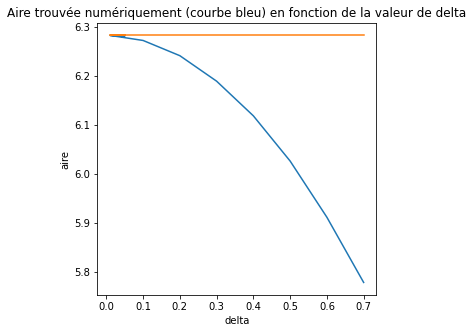

In [366]:
#on remarque la convergence vers pi, la valeur théorique
K2 = [level_curve_improved(cercle,1., 0.,delta = d,eps = 10**-6)+level_curve_improved(cercle2,2., 3.,delta = d,eps = 10**-6) for d in D]
S = [triangle_level2(k,P0) for k in K2]

plt.plot(D, S)
plt.xlabel('delta')
plt.ylabel('aire')
plt.title('Aire trouvée numériquement (courbe bleu) en fonction de la valeur de delta')
plt.plot(D,[2*np.pi for k in D])


In [298]:
# Evaluation de l'aire de l'ensemble des deux cercles disjoints, délimité par la liste de points K

# On crée une fonction discontinue qui vaut 1 à l'intérieur des cercles et 2 à l'extérieur
def deux_disques(x,y) :
    if Norme(x,y) <= 1 :
        return 1
    if cercle2(x,y) <= 1 :
        return 1
    else : 
        return 2
    
aera_squares(deux_disques, 1., 0.01, K[0],K[1])


2.9999996881198077
3.0
3.9999996881198077


6.2754

temps d'éxecution pour la méthode des carrés 123.17591309547424


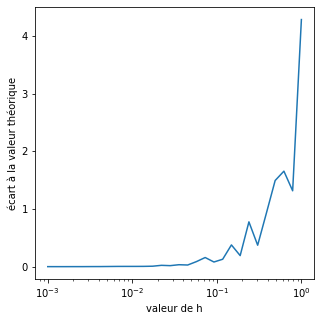

temps d'éxecution pour la méthode des triangles 0.4097909927368164


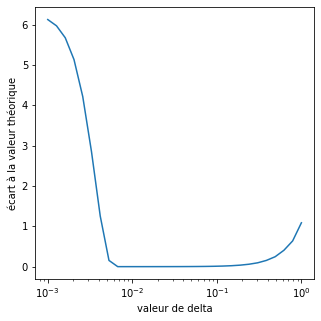

In [308]:
H = [10**(-k) for k in np.linspace(0,3,30)]
début = t.time()
Aire = [aera_squares(deux_disques, 1., h, K[0],K[1]) for h in H]
fin = t.time()
Erreur = [np.abs(Ah-2*np.pi) for Ah in Aire]
print(f"temps d'éxecution pour la méthode des carrés {fin-début}")

plt.xscale("log")
plt.xlabel('valeur de h')
plt.ylabel('écart à la valeur théorique')
plt.plot(H,Erreur)
plt.show()
      
K3 = [level_curve_improved(cercle,1., 0.,delta = d,eps = 10**-6)+level_curve_improved(cercle2,2., 3.,delta = d,eps = 10**-6) for d in H]
début2 = t.time()
AireTri = [triangle_level2(k,P0) for k in K3]
fin2 = t.time()
print(f"temps d'éxecution pour la méthode des triangles {fin2-début2}")
Erreur2 = [np.abs(Ah-2*np.pi) for Ah in AireTri]
plt.xscale("log")
plt.xlabel('valeur de delta')
plt.ylabel('écart à la valeur théorique')
plt.plot(H,Erreur2)
plt.show()


In [ ]:
Comparaison :
    
    - la méthode des triangles converge plus vite sans surprise par analogie avec la différence de rapidité de 
    convergence en dimension 1 entre la méthode des trapèzes (O(1/n^2) pour une fonction de classe C2) et celle
    des rectangles (O(1/n) pour une fonction de classe C1)
    - pour les zones constituees d ensemble disjoints (comme l exemple des deux cercles) la méthode des carrés
    semble améliorable car on crée un grand carré qui englobe les deux figures : il serait plus efficace de
    créer un carré autour de chaque cercle, ce qui diminuerait largement le nombre de test donc augmenterait
    la rapidité. La complexité est en c**2 avec c le coté du carré alors qu on pourrait atteindre une complexité
    de l ordre de l aire total en englobant chaque partie de l ensemble disjoint
    - il semblerait plus efficace aussi de faire non pas un carré mais un rectangle autour de la courbe (moins 
    grossier)
    - le temps de calcul est largement meilleur pour la méthode des triangles
    - il semble cependant que pour une précision trop importante dans le tracé de la courbe de niveau (delta
    trop faible) la méthode des triangles atteigne sa limite : l aire renvoyée est nulle. L aire
        de triangle trop "petits" est comptabilisée nulle. Cela vient peut-être de la façon dont l aire
        des triangles est calculée, il faudrait envisager une autre façon que le produit vectoriel